# **Predicting Cyberbullying**

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

## Importing libraries for processing textual data

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Uploading the data file

In [3]:
#uploading local saved excel/csv file to colab
from google.colab import files
uploaded = files.upload()

Saving formspring.csv to formspring (2).csv


In [4]:
df = pd.read_csv("formspring.csv")
df = df[df['ans'].notna()]


## Only considering the data in which all the three answers are same
##(ans1 = ans2 = ans3)

In [5]:
index = (df.ans1 == df.ans2) & (df.ans2 == df.ans3) & (df.ans1 == df.ans3)
df = df[index]
df.head()

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,NaN,No,0,NaN,No,0,NaN
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,<3,</3 ? haha jk! <33,None,No,0,NaN,No,0,NaN,No,0,NaN
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,NaN,No,0,NaN,No,0,NaN
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,NaN,No,0,NaN,No,0,NaN
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,NaN,No,0,NaN,No,0,NaN




### *   Since "post" contains both "ques" and "ans", we are considering only "post" 
### *   Dropping "userid", "asker", "severity" and "bully"







In [6]:
df = df[["post","ans1"]]
df.head()

,post,ans1
0,Q: what&#039;s your favorite song? :D<br>A: I ...,No
1,Q: <3<br>A: </3 ? haha jk! <33,No
2,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,No
3,Q: (:<br>A: ;(,No
4,Q: ******************MEOWWW*******************...,No


## Cleaning text data

*   Replacing all the symbols by space
*   Considering only numerals and alphabets

*   Removing stopwords
* Applying Porter Stemmer







In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    ps = PorterStemmer()
    text = ''.join([ps.stem(j) for j in text])

    return text
    
df['post'] = df['post'].apply(clean_text)


In [8]:
df.head()

,post,ans1
0,q whats favorite song da like many songs favorite,No
1,q 3a 3 haha jk 33,No
2,q hey angel duh sexya really thanks haha,No
3,q,No
4,q meowwwa rawr,No


## Splitting Train and Test data (Train = 80% and Test = 20%)

In [9]:
train1_size = int(len(df) * .8)
train1_description = df['post'][:train1_size]
train1_categories = df['ans1'][:train1_size]

test1_description = df['post'][train1_size:]
test1_categories = df['ans1'][train1_size:]

print('Train data size =', train1_description.shape[0])
print('Test data size =', test1_description.shape[0])

Train data size = 8843
Test data size = 2211


In [17]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import text, sequence
from keras import utils

## Tokenizing the words in text and creating matrix accordingly

In [18]:
max_words = 10000
tokenize = text.Tokenizer(num_words=max_words,char_level=False)
tokenize.fit_on_texts(train1_description) # only fit on train

x1_train = tokenize.texts_to_matrix(train1_description)
x1_test = tokenize.texts_to_matrix(test1_description)

In [19]:
print('Train data shape =', x1_train.shape)
print('Test data shape =', x1_test.shape)

Train data shape = (8843, 10000)
Test data shape = (2211, 10000)


## Label encoding the target variable

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
encoder = LabelEncoder()
encoder.fit(train1_categories)
y1_train = encoder.transform(train1_categories)
y1_test = encoder.transform(test1_categories)

In [22]:
num_classes = np.max(y1_train) + 1
y1_train = utils.to_categorical(y1_train, num_classes)
y1_test = utils.to_categorical(y1_test, num_classes)

## Importing libraries for building neural network

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

## Building the neural network

In [27]:

model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5120512   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 5,121,538
Trainable params: 5,121,538
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Training the model

In [30]:
batch_size = 32
epochs = 10   
history = model.fit(x1_train, y1_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
249/249 [==============================] - 8s 33ms/step - loss: 0.1673 - accuracy: 0.9632 - val_loss: 0.0731 - val_accuracy: 0.9774
Epoch 2/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0641 - accuracy: 0.9786 - val_loss: 0.0621 - val_accuracy: 0.9808
Epoch 3/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0370 - accuracy: 0.9876 - val_loss: 0.0628 - val_accuracy: 0.9808
Epoch 4/10
249/249 [==============================] - 8s 34ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 0.0652 - val_accuracy: 0.9831
Epoch 5/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0127 - accuracy: 0.9964 - val_loss: 0.0702 - val_accuracy: 0.9831
Epoch 6/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0733 - val_accuracy: 0.9853
Epoch 7/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0810 - val_accuracy: 0.9842

## Learning Curves

Plotting the accuracy vs epoch curve

Text(0, 0.5, 'Accuracy')

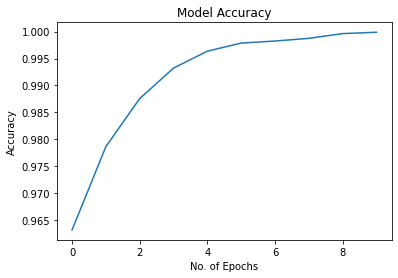

In [31]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')

Plotting the error vs epoch curve

Text(0, 0.5, 'Loss')

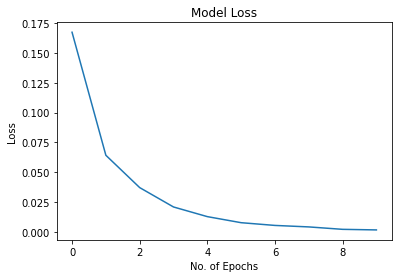

In [32]:
plt.figure()
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')

## Predicting the test results

In [33]:
y1_pred = (model.predict(x1_test)>0.5).astype('int32')
y1_test = y1_test.astype('int32')

Accuracy of the model over the test data

In [34]:
print(accuracy_score(y1_pred, y1_test))

0.9954771596562642


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2201
           1       0.50      0.50      0.50        10

   micro avg       1.00      1.00      1.00      2211
   macro avg       0.75      0.75      0.75      2211
weighted avg       1.00      1.00      1.00      2211
 samples avg       1.00      1.00      1.00      2211

